![alternative text](../../data/decision-tree_chatgpt.png)


In [1]:
import torch
import numpy as np
from sklearn.datasets import load_iris,make_classification
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib.pylab import plt

In [2]:
# Generate a synthetic dataset
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=2, random_state=0)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

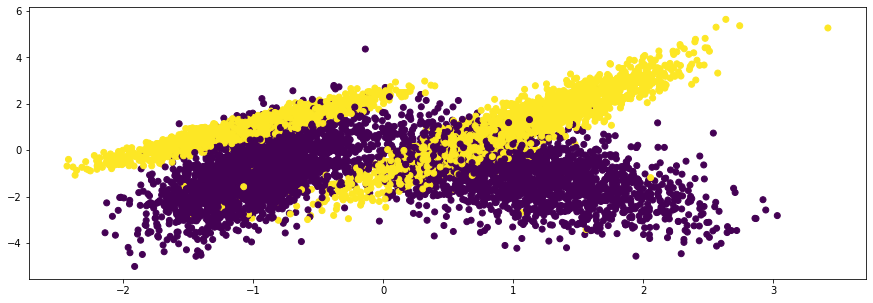

In [3]:
plt.figure(figsize=(15,5))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

In [4]:
# Define a decision tree node structure
class DecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, value=None, left=None, right=None):
        self.feature_index = feature_index  # Index of feature to split on
        self.threshold = threshold  # Threshold value to split on
        self.value = value  # Predicted value for the leaf node
        self.left = left  # Left subtree
        self.right = right  # Right subtree

In [5]:
# Define a simple decision tree class
class DecisionTree(DecisionTreeNode):
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # Maximum depth of the tree
        self.root = None  # Root node of the tree

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(y) <= 1 or torch.all(y == y[0]): # decision tree keeps splitting by new features until the max depth is reached or there are no nodes to split on 
            # Create a leaf node with the majority class
            return DecisionTreeNode(value=y.mode().values) 
        
        num_samples, num_features = X.shape
        if num_samples <= 1: #if there's only one sample left
            return DecisionTreeNode(value=y.mode().values) 
        
        unique_labels = torch.unique(y)# if there's only label left
        if len(unique_labels) == 1:
            return DecisionTreeNode(value=unique_labels[0])
        
        # Find the best split point
        best_feature, best_threshold = self._find_best_split(X, y) # at each depth, what is the best feature and threshold to split on
        if best_feature is None:
            return DecisionTreeNode(value=y.mode().values)
        
        # Split the data
        left_indices  = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        # recurse
        left_tree  = self._build_tree(X[left_indices] , y[left_indices] , depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return DecisionTreeNode(feature_index=best_feature, threshold=best_threshold, 
                                left=left_tree, right=right_tree)
    
    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gini = float('inf')
        best_feature   = None
        best_threshold = None
        #finding the best feature in X that has the lowest gini score
        for feature_index in range(num_features):
            thresholds = torch.unique(X[:, feature_index])
            for threshold in thresholds:# looping through each value in the feature set
                
                left_indices  = X[:, feature_index] <= threshold# values less than the threshold go to left sub-tree
                right_indices = X[:, feature_index] > threshold# values larger than the threshold go to right sub-tree
                
                left_gini  = self.calculate_gini(y[left_indices])# calculate the gini score for this threshold and feature
                right_gini = self.calculate_gini(y[right_indices])
                
                weighted_gini = (left_gini * torch.sum(left_indices) + right_gini * torch.sum(right_indices)) / num_samples
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature_index = feature_index
                    best_threshold = threshold
                    
        return best_feature_index, best_threshold
    
    def calculate_gini(self, labels):
        total_samples   = len(labels)
        _, class_counts = np.unique(labels, return_counts=True)
        class_probabilities = torch.tensor(class_counts) / total_samples
        gini = 1.0 - torch.sum(class_probabilities ** 2)
        return gini
    
    def _predict_single(self, node, sample):
        if node.value is not None:
            return node.value
        
        if sample[node.feature_index] < node.threshold:
            return self._predict_single(node.left, sample)
        else:
            return self._predict_single(node.right, sample)
    
    def predict(self, X):
        predictions = torch.zeros(X.shape[0])
        for i in range(X.shape[0]):
            predictions[i] = self._predict_single(self.root, X[i])
        return predictions


# Create and fit the decision tree


In [15]:
max_depth = 125 # higher the depth, more overfitting 
tree = DecisionTree(max_depth=max_depth)
tree.fit(X_train_tensor, y_train_tensor)

# Make predictions on the test data
predictions = tree.predict(X_test_tensor)

# Calculate accuracy
accuracy = (predictions == y_test_tensor).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8760


# Visualizing a decision tree decision boundary 

In [16]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 900), torch.linspace(y_min, y_max, 900))
mesh_data = torch.cat((xx.flatten().unsqueeze(1), yy.flatten().unsqueeze(1)), dim=1)

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z.reshape(xx.shape)


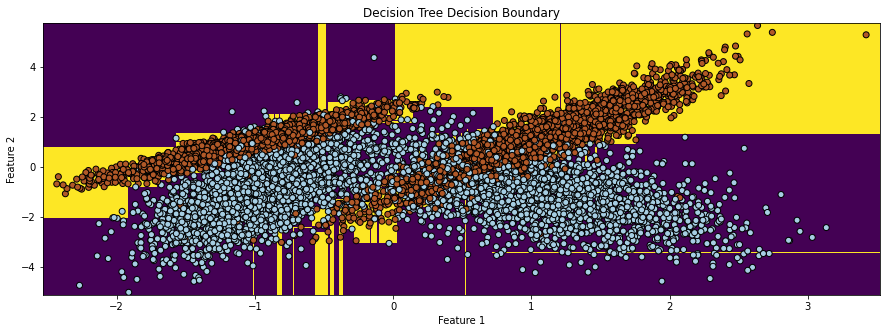

In [17]:
# Plot the decision boundary
plt.figure(figsize=(15,5))
plt.pcolormesh(xx, yy, Z2)

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Tree Decision Boundary')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

![alternative text](../../data/random-forest_chatgpt.png)
![alternative text](../../data/random-forest2_chatgpt.png)
![alternative text](../../data/random-forest3_chatgpt.png)


Following implementation will use our previously implemented decision trees to create forests. In this case, random forests can either aggregate the results from multiple decision trees or do majority votes when performing classifications. 

In [9]:
class RandomForest:
    def __init__(self, num_trees=10, max_depth=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        num_samples = X.shape[0]
        for _ in range(self.num_trees): # for each use a random se=ubset of data
            sample_indices = [np.random.randint(0, num_samples - 1) for _ in range(num_samples)]
            sampled_X = X[sample_indices]
            sampled_y = y[sample_indices]

            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(sampled_X, sampled_y)
            self.trees.append(tree)

    def _predict(self,X):
        predictions = torch.zeros((self.num_trees, X.shape[0]))
        for i, tree in enumerate(self.trees):
            predictions[i] = tree.predict(X)
        return predictions
    
    def predict_aggregate(self, X):
        predictions = self._predict(X)
        return np.int32(predictions.mean(dim=0)>0.5)
    
    def predict_majority(self, X):
        predictions = self._predict(X)
        majority_predictions = torch.mode(predictions, dim=0).values
        return majority_predictions

In [10]:
random_forest = RandomForest(num_trees=20, max_depth=5)
random_forest.fit(X_train_tensor, y_train_tensor)


In [11]:
# Make predictions on the test data
predictions = random_forest.predict_aggregate(X_test_tensor)

# Calculate accuracy
accuracy = (torch.tensor(predictions) == y_test_tensor).sum().item() / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

# Calculate mean squared error
mse = torch.mean((predictions - y_test_tensor) ** 2).item()
print(f"mse: {mse:.4f}")

Accuracy: 0.8900


You can random forest gets better test accuracy than decision trees given the same max depth. 